# Generating lognormal mock calalogs of objects with `nbodykit`

In this notebook, we generate lognormal mocks using `nbodykit` (https://nbodykit.readthedocs.io/), demonstrating how to add Redshift Space Distortions and a telescope beam smoothing effect. We also demonstrate how to calculate power spectrum multipoles using `nbodykit`'s own power spectrum measuring pipeline. Finally, we show how to add and clean foreground maps from data. This notebook is heavily based off `nbodykit`'s own cookbook for how to generate lognormal mock catalogs of objects, which can be found here: https://nbodykit.readthedocs.io/en/latest/cookbook/lognormal-mocks.html.

Note that while this notebook gives a general overview of how smoothed HI overdensity fields are generated using lognormal mocks for the companion paper, it does not cover all the nuances required to reproduce the exact results presented in it. For example, in the paper the box sizes are larger and the grid definition finer, requiring a longer computation time. Additionally, we have only used an example foreground map in this notebook, while in the analysis of the paper we generate a foreground map with the exact same redshift and box specifications for each case. Finally, in the companion paper we generate 10 different lognormal mocks and average over them, to reduce scatter, and don't include redshift space distortions.

In [1]:
# importing necesary packages
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

We start by specifying the redshift, comoving distance length and grid size of our simulation box. We also choose the bias and number density of the objects in the simulation. We refer to the axes as $(x, y, z)$ where $z$ represents the Line of Sight (redshift) direction.

In [3]:
# choose a redshift and bin width:
zz = 0.8

# choose a box size, in units Mpc/h:
lx, ly, lz = 1000, 1000, 1000
boxsize = [lx, ly, lz]

# choose number of grids on each side of the mesh:
Nx, Ny, Nz = 225, 225, 225
nmesh = [Nx, Ny, Nz]

# bias of objects:
b1 = 1.0

# number density of objects:
nbar = 30e-3

Next, specify a cosmology and generate the initial (linear) power spectrum:

In [4]:
from nbodykit.lab import *

In [5]:
# PLANCK15 cosmology:
cosmo = cosmology.Planck15
Om0 = cosmo.Om0
h = cosmo.h
H0 = 100*h

# generate underlying linear matter power spectrum:
Plin = cosmology.LinearPower(cosmo, zz, transfer="EisensteinHu")

## Generating lognormal catalog, no RSD and no beam

Now we have all the specifications required to build our first lognormal catalog. Note that what `nbodykit` first produces is a catalog, with columns "Position", "Velocity" and "VelocityOffset" (Kaiser RSD) for each object. In order to convert this catalog to a mesh of overdensity (second step below), we need to choose a mass assignment function that assigns galaxies to mesh grids based on their position. We select the Cloud in Cell interpolation (`resampler = 'cic'`) and the `CompensateCIC = True` parameter means that this will be corrected for when calculating the power spectrum.

In [6]:
# generating lognormal catalog:
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=nmesh, bias=b1, seed=42)
# convert the catalog to the mesh, with CIC interpolation and correction
mesh = cat.to_mesh(compensated=True, resampler='cic', position='Position')
mesh_array = mesh.preview(axes=[0,0,0])

Here is what a 2D projection of the density field described by the mesh, and what one redshift slice of this field look like:

Text(0.5, 1.0, '1 redshift slice')

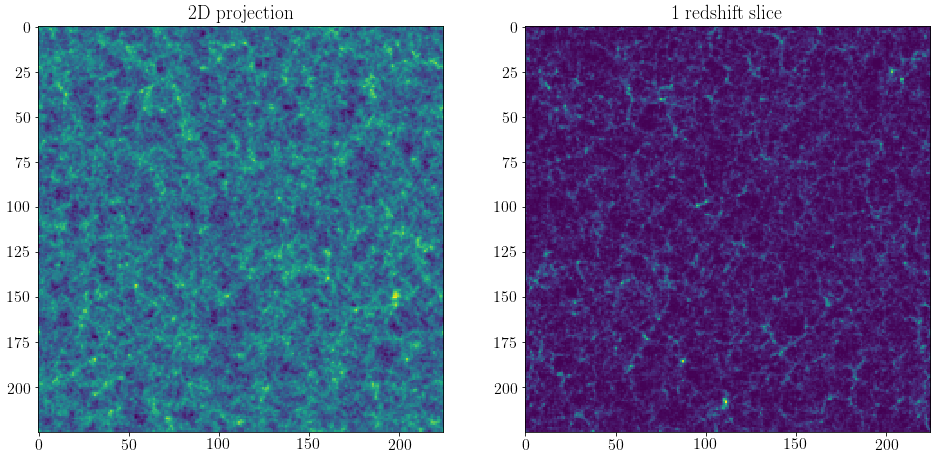

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mesh.preview(axes=[0,1]))
plt.title("2D projection")
plt.subplot(122)
plt.imshow(mesh_array[:,:,0])
plt.title("1 redshift slice")

Calculating the 2d power spectrum, and plotting (plotting function as seen in https://nbodykit.readthedocs.io/en/latest/cookbook/lognormal-mocks.html):

In [8]:
# compute the 2d P(k,mu) power, with 5 mu bins
r = FFTPower(mesh, mode='2d', Nmu=5, poles=[0,2,4])
pkmu = r.power

(0.01, 0.3)

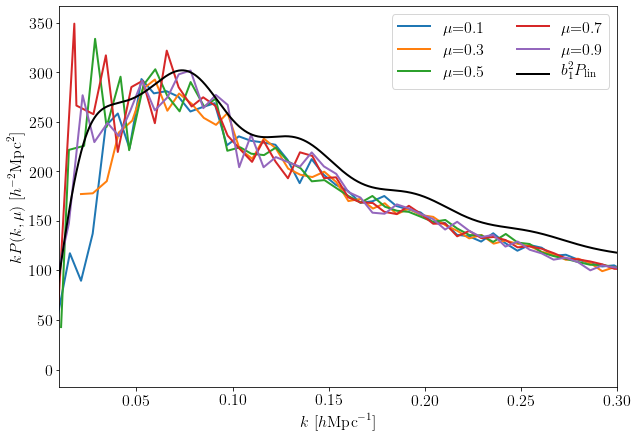

In [9]:
plt.figure(figsize=(10,7))

# plot each mu bin:
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i]
    label = r'$\mu$=%.1f' %pkmu.coords['mu'][i]
    # note that we are subtracting shot noise:
    plt.plot(Pk['k'], Pk['k'] * (Pk['power'].real - Pk.attrs['shotnoise']), label=label, lw=2)

# plot the biased linear power spectrum (our input):
k = np.linspace(0, 0.3, 1000)
plt.plot(k, k * b1**2 * Plin(k), c='k', label=r'$b_1^2 P_\mathrm{lin}$', lw=2)

# add a legend and axes labels:
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$kP(k, \mu)$ [$h^{-2} \mathrm{Mpc}^2$]")
plt.xlim(0.01, 0.3)

In this figure, we see the power spectrum in real-space is independent of $\mu$, as expected. At low $k$, the measured power agrees with the biased linear power $b^{2}P_\mathrm{lin}$. But at high $k$, we see the effects of applying the Zel’dovich approximation to the density field, mirroring the effects of nonlinear evolution. [credit: https://nbodykit.readthedocs.io/en/latest/cookbook/lognormal-mocks.html]

## Adding Redshift Space Distortions

Recall that when we generated a catalog of objects, there was a column names "VelocityOffset." This column contains the contribution to the position of each object due to the quasi-linear Kaiser RSD effect. If we add this column to the original "Position" column, we will have the position of each object in the case of this RSD effect. We do this along the Line of Sight axis for each object.

In [10]:
# define the LoS axis as the z-axis:
LOS = [0,0,1]
# adding velocity offset due to RSD to each object position along LoS:
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset'] * LOS
# convert the catalog to the mesh, with CIC interpolation and correction and now including RSD:
mesh_RSD = cat.to_mesh(compensated=True, resampler='cic', position='RSDPosition')
mesh_RSD_array = mesh_RSD.preview(axes=[0,0,0])
# calculate 2d power spectrum again:
r_RSD = FFTPower(mesh_RSD, mode='2d', Nmu=5, poles=[0,2,4])

Now that we have RSD effects included in our catalog, we can demonstrate how to obtain the power spectrum multipoles and how to plot them.

In [11]:
# obtaining power spectrum multipoles:
k = r_RSD.poles['k']
# for the monopole, note that we subtract the shot noise:
p0 = r_RSD.poles['power_0'].real - r_RSD.attrs['shotnoise']
p2 = r_RSD.poles['power_2'].real
p4 = r_RSD.poles['power_4'].real
pkmults = [p0, p2, p4]

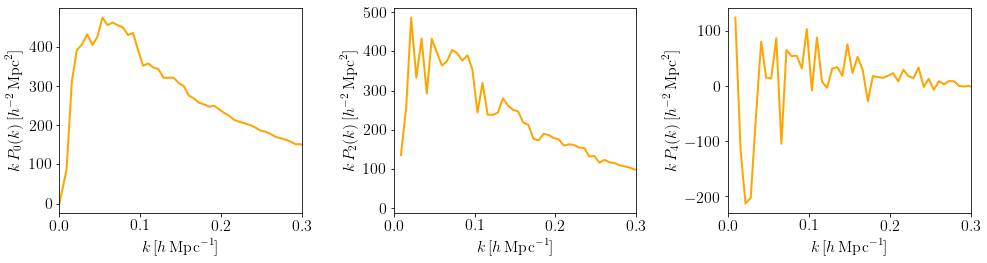

In [12]:
# plotting multipoles:
plt.figure(figsize=(14,7))
for i in range(3):
    plt.subplot(231+i)
    plt.plot(k,k*pkmults[i],color='Orange', lw=2)
    plt.xlabel(r'$k \, [h \, {\rm Mpc}^{-1}]$')
    plt.ylabel(r'$k \,P_{%s}(k) \, $[$h^{-2} \, {\rm Mpc}^2$]'%(i*2))
    plt.xlim(0,0.3)
plt.tight_layout()
plt.show()

## Generating HI temperature overdensity field

To transform our overdensity field into an HI temperature overdensity field, we simply multiply it by the mean HI temperature at the given redshift, given by the model [see Battye et al. 2013]:

$$ \overline{T}\hspace{-0.5mm}_{\rm HI}(z) = 180\Omega_{\rm HI}(z)h\frac{(1+z)^2}{H(z)/H_0} \, {\text{mK}} $$

Where for simplicity we take the HI density abundance $\Omega_{\rm HI}(z)$ at our redshift to be $\Omega_{\rm HI} = 4.3 \times 10^{-4}$, consistent with Masui et al. (2013) constraints.

In [13]:
# Define E(z) = H(z)/H0
def E(z):
    E2 = 1 - Om0 + Om0*pow(1+z,3)
    return np.sqrt(E2)

# define mean HI temperature model, units mK
def TbarModel(z):
    OmegaHI = 4.3e-4 # consistent with Masui et al. (2013) constraints
    return 180 * OmegaHI * h * (1+z)**2 / E(z)

# multiplying overdensity field by mean HI temperature:
tHI = TbarModel(zz)
mesh_RSD_tHI = tHI*mesh_RSD_array

## Smoothing overdensity field with telescope beam

We now take our overdensity field (with RSD) and demonstrate the effects of smoothing the field with a telescope beam.

In [14]:
from scipy import fftpack

In [22]:
# Define E(z) = H(z)/H0
def E(z):
    E2 = 1 - Om0 + Om0*pow(1+z,3)
    return np.sqrt(E2)

# Define the comoving distances, in units Mpc
def r_comoving(z):
    c_km = 3e5  # speed of light in km per second
    func = lambda z: (c_km/H0)/E(z)
    return scipy.integrate.romberg(func,0,z)

# Smooth an image with telescope beam:
def smoothimage(image, R_beam):
    #Create Gaussian field
    x = xbincentres
    y = ybincentres[:,np.newaxis]
    x0 = xmin+xwidth/2
    y0 = ymin+ywidth/2
    gaussian = np.exp(-0.5 * (((x-x0)/R_beam)**2 + ((y-y0)/R_beam)**2))
    gaussian = np.swapaxes(gaussian,0,1)
    A = np.sum(gaussian)
    gaussian = gaussian/A #normalise gaussian so that all pixels sum to 1
    ft = fftpack.fft2(image)
    ft_gauss=fftpack.fft2(gaussian)
    smoothimage = fftpack.ifft2(ft*ft_gauss)
    smoothimage = np.real(smoothimage)
    #Now shift the quadrants around into correct position
    return fftpack.fftshift(smoothimage)

# smooth a whole mesh with telescope beam:
def smooth_mesh(input_mesh, nz, R_beam, boxsize):
    input_mesh_Beam = []
    # iterate through each z-slice, smoothing each one:
    for i in range(nz):
        input_mesh_Beam.append(list(smoothimage(input_mesh[:,:,i],R_beam)))
    # Swap axes to have redshift at last axis again:
    input_mesh_Beam = np.swapaxes(input_mesh_Beam,0,1)
    input_mesh_Beam = np.swapaxes(input_mesh_Beam,1,2)
    # Convert to ArrayMesh object if desired:
    #input_mesh_Beam = ArrayMesh(input_mesh_Beam, BoxSize=boxsize)
    return input_mesh_Beam

Along the $x$ and $y$ axes, we obtain the center of each bin (the number and position of bins is determined by the number of grids on each side, namely $Nx$ and $Ny$). We also calculate the physical smoothing scale of the telescope beam (in comoving distance units) from the full-width-half-maximum of the beam in degrees.

In [23]:
# x and y bins, to be used for smoothing:
xmin, ymin = 0, 0
xwidth, ywidth = lx, ly
xbins = np.linspace(xmin,lx,Nx+1)
ybins = np.linspace(ymin,ly,Ny+1)
xbincentres = xbins+(xbins[1]-xbins[0])/2
xbincentres = xbins[:len(xbins)-1] # remove last value since this is outside of bins
ybincentres = ybins+(ybins[1]-ybins[0])/2
ybincentres = ybins[:len(ybins)-1] # remove last value since this is outside of bins

# beam FWHM in degrees:
beam_fwhm = 1
# physical smoothing scale of beam, in Mpc/h:
R_beam = np.radians(beam_fwhm/(2*np.sqrt(2*np.log(2))))*r_comoving(zz)*h

In [24]:
# smoothing the mesh with beam:
mesh_RSD_Beam = smooth_mesh(mesh_RSD_tHI, Nz, R_beam, boxsize)

Here is what one redshift slice looks like before and after smoothing with the beam:

Text(0.5, 1.0, '1 redshift slice, with beam')

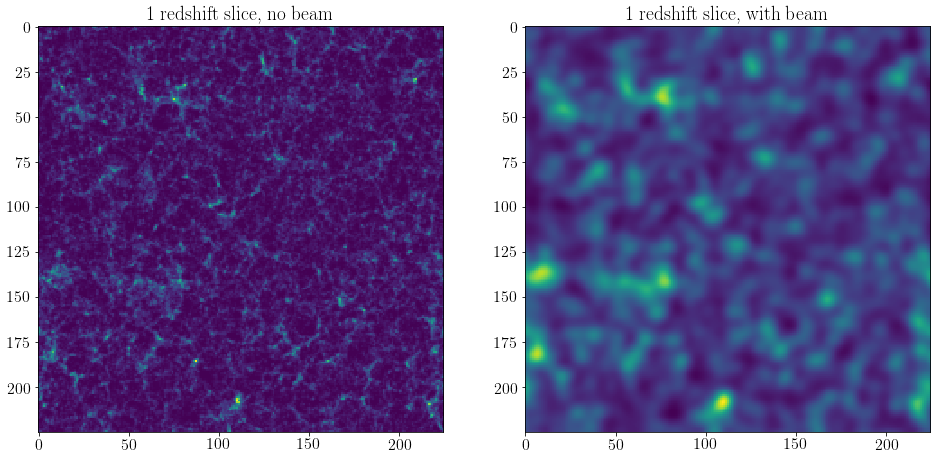

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mesh_RSD_array[:,:,0])
plt.title("1 redshift slice, no beam")
plt.subplot(122)
plt.imshow(mesh_RSD_Beam[:,:,0])
plt.title("1 redshift slice, with beam")

## Adding and subtracting foregrounds

We can also add foregrounds and subtract them using FastICA.

In [26]:
from sklearn.decomposition import FastICA

In [27]:
def FASTICAclean(Input, N_IC=4):
    # Check shape of input array. If flat data cube, collapse (ra,dec) structure
    #    to (Nz,Npix) structure:
    axes = np.shape(Input)
    if len(axes)==3: Input = np.reshape(Input,(axes[0],axes[1]*axes[2]))
    Input = np.swapaxes(Input,0,1) #Put in [npix, nz] form which is req'd for FASTICA
    ica = FastICA(n_components=N_IC, whiten=True)
    S_ = ica.fit_transform(Input) # Reconstruct signals
    A_ = ica.mixing_ # Get estimated mixing matrix
    Recon_FG = np.dot(S_, A_.T) + ica.mean_ #Reconstruct foreground
    Residual = Input - Recon_FG #Residual of fastICA is HI plus any Noise
    Residual = np.swapaxes(Residual,0,1) #return to [nz, npix] form
    if len(axes)==3: Residual = np.reshape(Residual,(axes[0],axes[1],axes[2])) #Rebuild if Input was 3D datacube
    return Residual

First, we load the example foreground map and add it to our RSD mesh. Then, we smooth this and perform the FastICA foreground clean.

In [28]:
# loading and reshaping FG map so that z axis is last axis:
mesh_FG = np.load('../inputs/dT_FG_z=0.8.npy')
mesh_FG = np.reshape(mesh_FG, (np.shape(mesh_FG)[0], np.shape(mesh_FG)[1], np.shape(mesh_FG)[2]))
# adding FG map to our (not smoothed) RSD mesh:
mesh_addFG = mesh_RSD_array + mesh_FG
# smooth this FG added map with beam:
mesh_addFG_smooth = smooth_mesh(mesh_addFG, Nz, R_beam, boxsize)
# perform the FG clean:
mesh_FGclean = FASTICAclean(mesh_addFG_smooth, N_IC=4)

We now plot the case of one redshift slice before having foregrounds added and after having foregrounds added and subtracted.

Text(0.5, 1.0, '1 redshift slice, foreground subtracted')

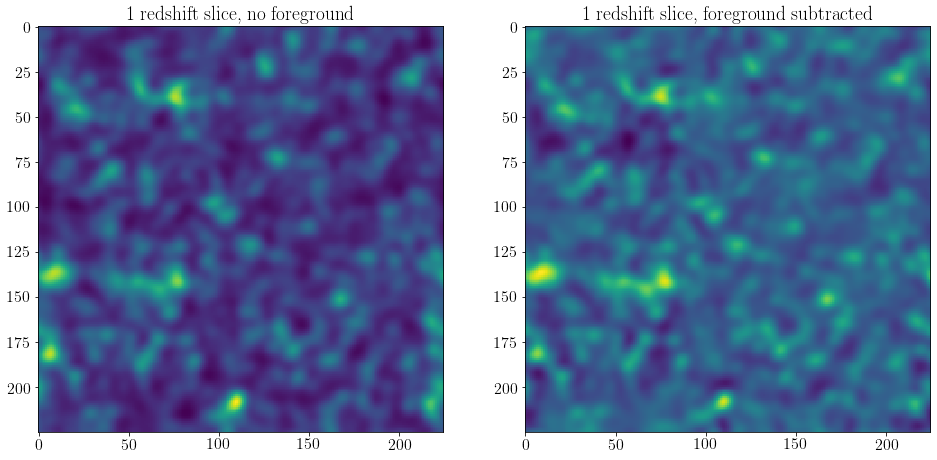

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mesh_RSD_Beam[:,:,0])
plt.title("1 redshift slice, no foreground")
plt.subplot(122)
plt.imshow(mesh_FGclean[:,:,0])
plt.title("1 redshift slice, foreground subtracted")